In [1]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt
from pandas.plotting import lag_plot


In [2]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [3]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

merlin = df[df['empresa'] == 'Merlin Properties']

merlin.shape

(1325, 10)

In [4]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

merlin = merlin [['date','open','high','low','close','adj close']]

merlin.shape

(1325, 6)

In [5]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

merlin['date'] = pd.to_datetime(merlin['date'], format="%Y-%m-%d")

merlin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1325 entries, 32089 to 33413
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1325 non-null   datetime64[ns]
 1   open       1325 non-null   float64       
 2   high       1325 non-null   float64       
 3   low        1325 non-null   float64       
 4   close      1325 non-null   float64       
 5   adj close  1325 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.5 KB


In [6]:
# Paso 5: Ordenar el DF por fecha

merlin.sort_values(by='date',ascending= True, inplace=True)

merlin.head()

,date,open,high,low,close,adj close
32526,2019-01-02,10.755,10.795,10.525,10.770,8.105373
32091,2019-01-03,10.705,10.740,10.570,10.680,8.037642
32977,2019-01-04,10.795,10.895,10.670,10.795,8.124188
32975,2019-01-07,10.790,10.850,10.755,10.810,8.135477
32974,2019-01-08,10.810,11.110,10.800,11.060,8.323626


In [7]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

merlin = merlin[(merlin['date'] >= fecha_inicio) & (merlin['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

merlin.shape

(812, 6)

In [8]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=merlin['date'].min(), end=merlin['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

merlin = merlin.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

merlin = merlin.rename(columns={'index': 'date'})


In [9]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

merlin.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,7.790,7.910,7.545,7.560,6.039270
1,2021-01-05,7.575,7.735,7.505,7.710,6.159097
2,2021-01-06,7.715,7.785,7.670,7.695,6.147114
3,2021-01-07,7.780,7.800,7.640,7.765,6.203033
4,2021-01-08,7.800,7.815,7.680,7.705,6.155103
5,2021-01-09,NaN,NaN,NaN,NaN,NaN
6,2021-01-10,NaN,NaN,NaN,NaN,NaN
7,2021-01-11,7.640,7.855,7.580,7.615,6.083207
8,2021-01-12,7.640,7.725,7.560,7.635,6.099183
9,2021-01-13,7.670,7.755,7.630,7.745,6.187057


In [10]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

merlin = merlin.fillna(method='ffill')

In [11]:
# Paso 10: Comprobar que se han introducido los valores correctamente


merlin.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,7.790,7.910,7.545,7.560,6.039270
1,2021-01-05,7.575,7.735,7.505,7.710,6.159097
2,2021-01-06,7.715,7.785,7.670,7.695,6.147114
3,2021-01-07,7.780,7.800,7.640,7.765,6.203033
4,2021-01-08,7.800,7.815,7.680,7.705,6.155103
5,2021-01-09,7.800,7.815,7.680,7.705,6.155103
6,2021-01-10,7.800,7.815,7.680,7.705,6.155103
7,2021-01-11,7.640,7.855,7.580,7.615,6.083207
8,2021-01-12,7.640,7.725,7.560,7.635,6.099183
9,2021-01-13,7.670,7.755,7.630,7.745,6.187057


In [12]:
# Paso 11: Establecer columna 'date' como índice para modelo

merlin = merlin.set_index('date')

merlin.head(10)

,open,high,low,close,adj close
date,,,,,
2021-01-04,7.790,7.910,7.545,7.560,6.039270
2021-01-05,7.575,7.735,7.505,7.710,6.159097
2021-01-06,7.715,7.785,7.670,7.695,6.147114
2021-01-07,7.780,7.800,7.640,7.765,6.203033
2021-01-08,7.800,7.815,7.680,7.705,6.155103
2021-01-09,7.800,7.815,7.680,7.705,6.155103
2021-01-10,7.800,7.815,7.680,7.705,6.155103
2021-01-11,7.640,7.855,7.580,7.615,6.083207
2021-01-12,7.640,7.725,7.560,7.635,6.099183


In [13]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

merlin.index = pd.DatetimeIndex(merlin.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

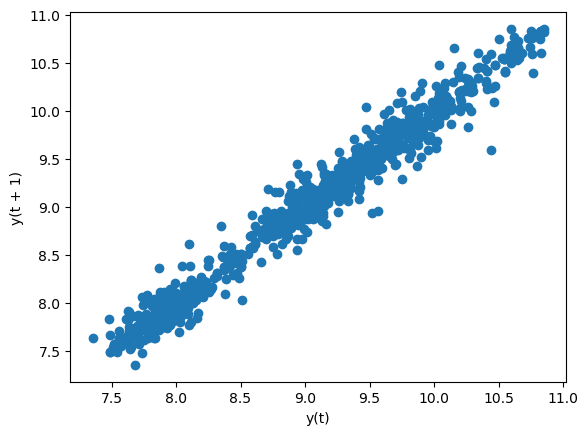

In [14]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

lag_plot(merlin.close)

In [15]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [16]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = merlin.close[:-10], merlin.close[-10:]

train.shape, test.shape

((1143,), (10,))

In [17]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [18]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(merlin.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    9.189337
2024-02-22    9.188684
2024-02-23    9.188039
2024-02-24    9.187403
2024-02-25    9.186777
2024-02-26    9.186158
2024-02-27    9.185548
2024-02-28    9.184947
2024-02-29    9.184354
2024-03-01    9.183769
Freq: D, dtype: float64

In [19]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    9.180
2024-02-22    9.220
2024-02-23    9.205
2024-02-24    9.205
2024-02-25    9.205
2024-02-26    9.190
2024-02-27    9.130
2024-02-28    8.855
2024-02-29    8.755
2024-03-01    8.905
Freq: D, Name: close, dtype: float64

In [20]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.11908935393963808

In [21]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,9.180,9.189337,0.009337
2024-02-22,9.220,9.188684,-0.031316
2024-02-23,9.205,9.188039,-0.016961
2024-02-24,9.205,9.187403,-0.017597
2024-02-25,9.205,9.186777,-0.018223
2024-02-26,9.190,9.186158,-0.003842
2024-02-27,9.130,9.185548,0.055548
2024-02-28,8.855,9.184947,0.329947
2024-02-29,8.755,9.184354,0.429354
2024-03-01,8.905,9.183769,0.278769
